<a href="https://colab.research.google.com/github/amballa-mahesh/Deep_learning_facemask_detection/blob/main/Deep_learning_facemask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [2]:
import os

In [3]:
image_names = os.listdir('/content/mydrive/MyDrive/DeeplearningImages')

In [4]:
labels = []
for image in image_names:
  name = image.split('.')[0]
  if name == 'with_mask':
    labels.append('1')
  else:
    labels.append('0')

In [5]:
import pandas as pd
import numpy as np

In [6]:
df = pd.DataFrame({'file_name':image_names,'labels':labels})
df.shape

(1376, 2)

In [7]:
df.head()

,file_name,labels
0,with_mask. (70).jpg,1
1,with_mask. (511).jpg,1
2,with_mask. (83).jpg,1
3,with_mask. (64).jpg,1
4,with_mask. (55).jpg,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1376 entries, 0 to 1375
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1376 non-null   object
 1   labels     1376 non-null   object
dtypes: object(2)
memory usage: 21.6+ KB


In [9]:
df['labels'].value_counts()

1    690
0    686
Name: labels, dtype: int64

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing.image import load_img

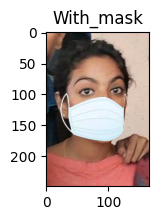

In [11]:
i = 0
image = load_img('/content/mydrive/MyDrive/DeeplearningImages/'+ str(df['file_name'][i]))
plt.figure(figsize = (4,2))
if df['labels'][i]==0:
  title = 'Without_mask'
else:
  title = 'With_mask'
plt.title(title)
plt.imshow(image)
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_df,test_df = train_test_split(df,random_state = 123,test_size= 0.2,stratify = df['labels'])

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
train_data = ImageDataGenerator(rescale = 1./255,
                                rotation_range =20,
                                horizontal_flip= True,
                                vertical_flip = True)
test_data =ImageDataGenerator(rescale =1./255)

In [16]:
train_data_generator = train_data.flow_from_dataframe(dataframe = train_df,
                                                      directory='/content/mydrive/MyDrive/DeeplearningImages',
                                                      target_size =(224,224),
                                                      x_col = 'file_name',
                                                      y_col = 'labels',
                                                      color_mode = 'rgb',
                                                      class_mode = 'binary',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      validate_filenames = True
                                                      )

Found 1100 validated image filenames belonging to 2 classes.


In [17]:
test_data_generator = test_data.flow_from_dataframe(dataframe = test_df,
                                                      directory='/content/mydrive/MyDrive/DeeplearningImages',
                                                      target_size =(224,224),
                                                      x_col = 'file_name',
                                                      y_col = 'labels',
                                                      color_mode = 'rgb',
                                                      class_mode = 'binary',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      validate_filenames = True)

Found 276 validated image filenames belonging to 2 classes.


In [18]:
from tensorflow.keras import applications

In [19]:
base_model = tensorflow.keras.applications.MobileNetV2(weights = 'imagenet',
                                                       include_top = False,
                                                       input_shape = (224,224,3))
base_model.trainable = False
base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [20]:
flatten_layer = tensorflow.keras.layers.Flatten()
output_layer  = tensorflow.keras.layers.Dense(1, activation = 'sigmoid')

In [21]:
final_model = tensorflow.keras.Sequential([base_model,flatten_layer,output_layer])

In [22]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 1)                 62721     
                                                                 
Total params: 2,320,705
Trainable params: 62,721
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
mc = tensorflow.keras.callbacks.ModelCheckpoint(filepath = '/content/best_model.h5',
                                                               monitor = 'val_loss',
                                                               mode = 'min',
                                                               save_best_only = True)
es= tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                 mode='max',
                                                 patience=5,
                                                 restore_best_weights= True,
                                                 )

In [24]:
final_model.compile(optimizer = 'adam',
                    loss = 'binary_crossentropy', 
                    metrics ='accuracy')

In [25]:
history = final_model.fit(train_data_generator,
                          steps_per_epoch =train_data_generator.samples//32,
                          validation_data = test_data_generator,
                          validation_steps = test_data_generator.samples//32,
                          epochs = 30,
                          callbacks = [mc,es])

Epoch 1/30
34/34 [==============================] - 34s 669ms/step - loss: 0.2079 - accuracy: 0.9513 - val_loss: 0.0161 - val_accuracy: 0.9961
Epoch 2/30
34/34 [==============================] - 19s 561ms/step - loss: 0.0909 - accuracy: 0.9860 - val_loss: 0.0111 - val_accuracy: 0.9922
Epoch 3/30
34/34 [==============================] - 20s 598ms/step - loss: 0.0473 - accuracy: 0.9906 - val_loss: 0.0662 - val_accuracy: 0.9844
Epoch 4/30
34/34 [==============================] - 23s 688ms/step - loss: 0.0646 - accuracy: 0.9897 - val_loss: 0.0719 - val_accuracy: 0.9844
Epoch 5/30
34/34 [==============================] - 26s 767ms/step - loss: 0.1010 - accuracy: 0.9888 - val_loss: 0.0306 - val_accuracy: 0.9883
Epoch 6/30
34/34 [==============================] - 24s 715ms/step - loss: 0.0853 - accuracy: 0.9878 - val_loss: 2.7230e-04 - val_accuracy: 1.0000
Epoch 7/30
34/34 [==============================] - 20s 579ms/step - loss: 0.0634 - accuracy: 0.9916 - val_loss: 0.0140 - val_accuracy: 0.

In [30]:
history.history

{'loss': [0.20792743563652039,
  0.09087716042995453,
  0.04726777970790863,
  0.06457100063562393,
  0.10099179297685623,
  0.0853462889790535,
  0.0633658766746521,
  0.00965926330536604,
  0.010804109275341034,
  0.043605025857686996,
  0.040816064924001694],
 'accuracy': [0.9513108730316162,
  0.9859550595283508,
  0.9906367063522339,
  0.9897003769874573,
  0.9887640476226807,
  0.987827718257904,
  0.9915730357170105,
  0.9971910119056702,
  0.9971910119056702,
  0.9953183531761169,
  0.9934456944465637],
 'val_loss': [0.016084155067801476,
  0.011122453026473522,
  0.06624169647693634,
  0.07185500860214233,
  0.03058646060526371,
  0.0002722994249779731,
  0.01399217452853918,
  0.0016034544678404927,
  0.036013998091220856,
  0.05225519835948944,
  0.002073905663564801],
 'val_accuracy': [0.99609375,
  0.9921875,
  0.984375,
  0.984375,
  0.98828125,
  1.0,
  0.98828125,
  1.0,
  0.99609375,
  0.99609375,
  1.0]}

In [27]:
print('Training Accuracy Score: ',np.mean(history.history['accuracy']).round(2))
print('Validation Accuracy Score: ',np.mean(history.history['val_accuracy']).round(2))
print('Training Loss: ',np.mean(history.history['loss']).round(2))
print('Validation Loss: ',np.mean(history.history['val_loss']).round(2))

Training Accuracy Score:  0.99
Validation Accuracy Score:  0.99
Training Loss:  0.07
Validation Loss:  0.03


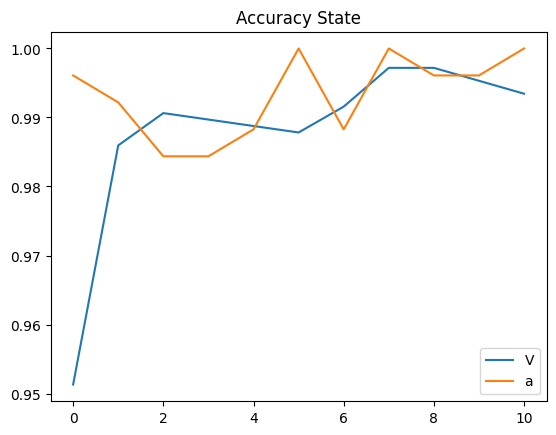

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend('Training Accuracy Score')
plt.legend('Validation Accuracy Score')
plt.title('Accuracy State')
plt.show()

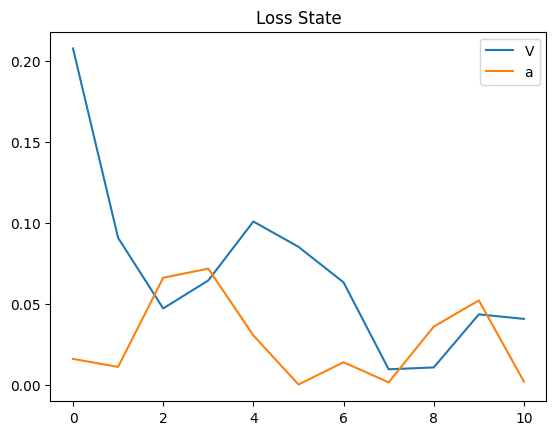

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend('Training Loss Score')
plt.legend('Validation Loss Score')
plt.title('Loss State')
plt.show()

In [31]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img,img_to_array
best_model = load_model("/content/best_model.h5")

In [32]:
def image_treat(image):
  image = img_to_array(image)
  image = image/255
  image_change = np.expand_dims(image,axis=0)
  return(image_change)

In [65]:
image_names = os.listdir('/content/mydrive/MyDrive/DeeplearningImages')
len(image_names)

1376

1/1 [==============================] - 0s 22ms/step


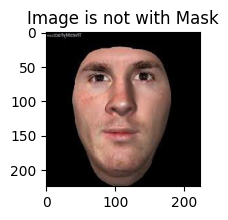

1/1 [==============================] - 0s 23ms/step


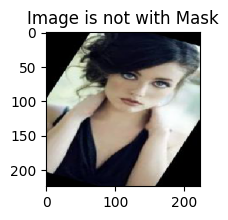

1/1 [==============================] - 0s 22ms/step


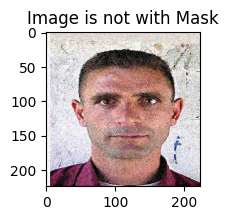

1/1 [==============================] - 0s 24ms/step


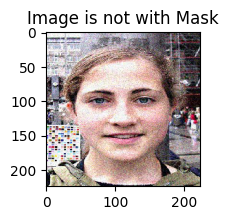

1/1 [==============================] - 0s 22ms/step


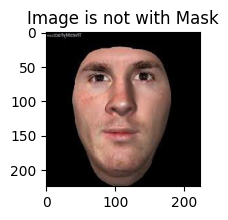

1/1 [==============================] - 0s 23ms/step


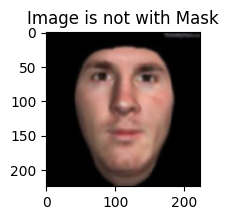

1/1 [==============================] - 0s 22ms/step


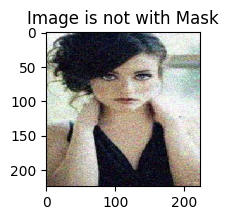

1/1 [==============================] - 0s 24ms/step


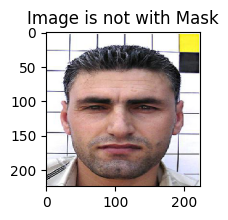

1/1 [==============================] - 0s 33ms/step


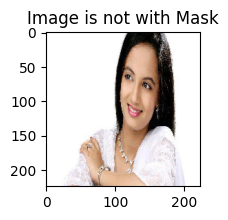

1/1 [==============================] - 0s 23ms/step


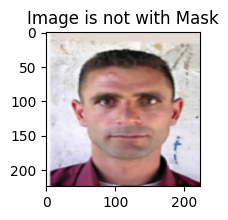

1/1 [==============================] - 0s 22ms/step


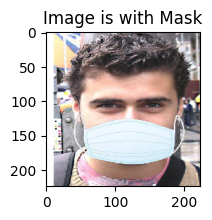

1/1 [==============================] - 0s 22ms/step


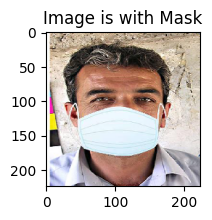

1/1 [==============================] - 0s 24ms/step


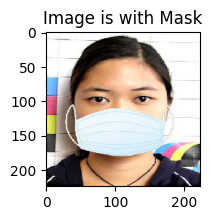

1/1 [==============================] - 0s 22ms/step


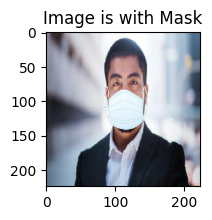

1/1 [==============================] - 0s 22ms/step


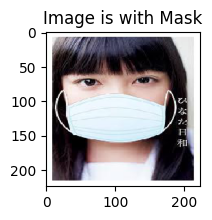

1/1 [==============================] - 0s 28ms/step


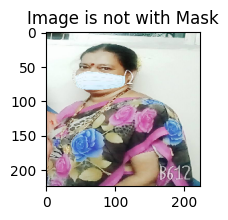

1/1 [==============================] - 0s 23ms/step


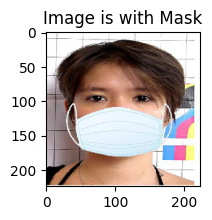

1/1 [==============================] - 0s 23ms/step


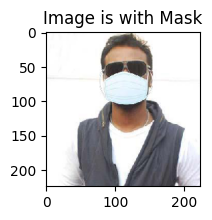

1/1 [==============================] - 0s 22ms/step


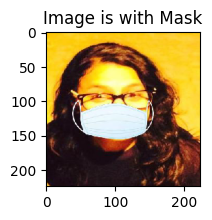

1/1 [==============================] - 0s 26ms/step


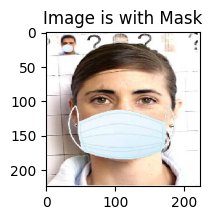

In [76]:
image_names = os.listdir('/content/mydrive/MyDrive/DeeplearningImages')
for i in range(990,1010):
  image = load_img('/content/mydrive/MyDrive/DeeplearningImages/'+str(image_names[i]),target_size=(224,224)) 
  image_change = image_treat(image)
  pred = best_model.predict(image_change).round()
  predict_result=''
  if pred[0] == 1:
    predict_result = 'Image is with Mask'
  else:
    predict_result = 'Image is not with Mask'
  plt.figure(figsize = (2,2))
  plt.imshow(image)
  plt.title(predict_result)
  plt.show()